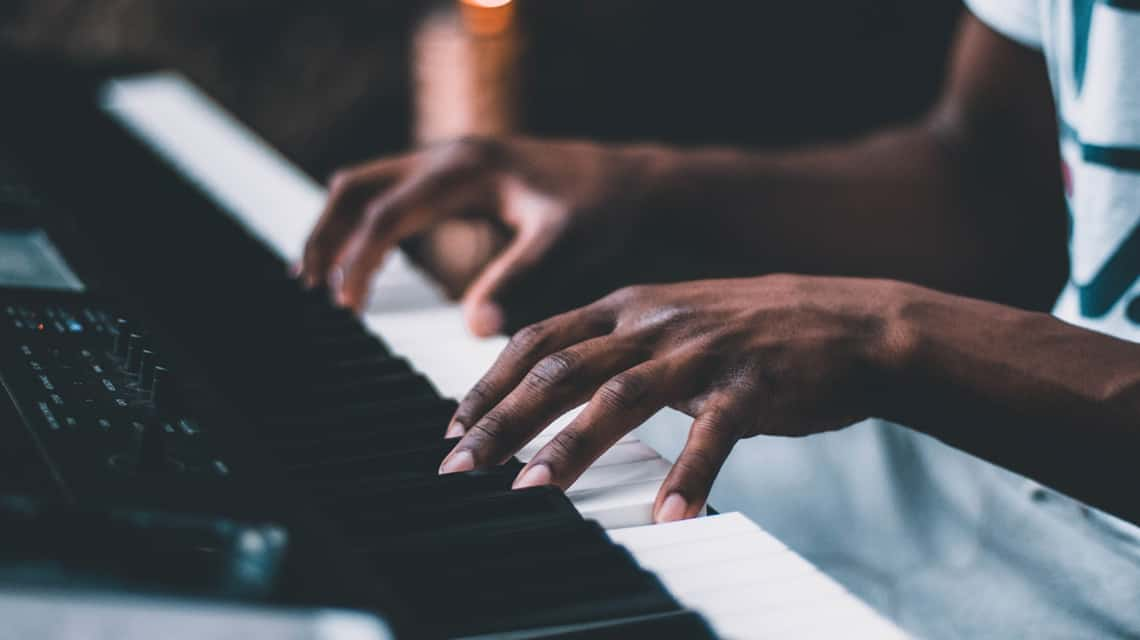

# Data Representation

In [273]:
!pip install mido
!pip install librosa

In [274]:
import mido
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import string

In [275]:
import mido
midis = []

for data in os.listdir('phonk_data'):
    midi = mido.MidiFile('phonk_data/{}'.format(data), clip=True)
    midis.append(midi)


print(len(midis))

24


In [276]:
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

In [277]:
def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

In [278]:
def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [279]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

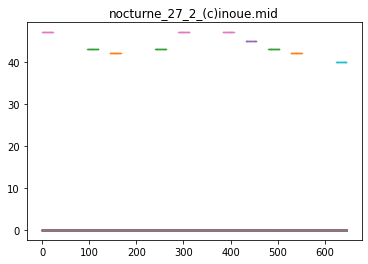

In [280]:
result_array = mid2arry(midis[6])
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("nocturne_27_2_(c)inoue.mid")
plt.show()

In [281]:
lam = lambda x: mid2arry(x)
midis = np.array([lam(midi) for midi in midis])

<ipython-input-281-b8527057802e>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  midis = np.array([lam(midi) for midi in midis])


In [282]:
def arry2mid(ary, tempo=500000):
    # get the difference
    new_ary = np.concatenate([np.array([[0] * 88]), np.array(ary)], axis=0)
    changes = new_ary[1:] - new_ary[:-1]
    # create a midi file with an empty track
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    # add difference in the empty track
    last_time = 0
    for ch in changes:
        if set(ch) == {0}:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_vol = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_vol):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=n + 21, velocity=v, time=new_time))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=n + 21, velocity=0, time=new_time))
                first_ = False
            last_time = 0
    return mid_new

# Tokenization

In [293]:
np.set_printoptions(threshold=np.inf)
midis[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 126,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 126,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      

In [249]:
def arry2chd(ary):
    res = np.zeros(ary.shape[0] + 1, dtype='object')
    res[0] = ' '
    element = []
    for i in range(len(ary)):
        for j in range(len(ary[i])):
            if ary[i][j] != 0:
                note = librosa.midi_to_note(j, unicode=False)
                element.append(note)
        element = '|'.join(element)
        if element == '':
            element = ' '
        res[i+1] = element
        element = []
    
    return res

In [384]:
## Only for lined samples with 150 tempo

def compress(ary):
    res = np.array(ary[0])
    temp = 0
    while temp <= len(ary):
        res = np.append(res, ary[temp])
        temp = temp + 24
    return res

In [251]:
lam = lambda x: arry2chd(x)
midis = np.array([lam(midi) for midi in midis])

<ipython-input-251-587198ebf40c>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  midis = np.array([lam(midi) for midi in midis])


In [252]:
lam = lambda x: compress(x)
midis = np.array([lam(midi) for midi in midis])

<ipython-input-252-adeffc864692>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  midis = np.array([lam(midi) for midi in midis])


In [253]:
#complete compositions to make them equal sized
for i in range(len(midis)):
    for j in range(32 - len(midis[i])):
        midis[i] = np.append(midis[i], ' ')

In [254]:
tokens = set()

for midi in midis:
    for element in midi:
        tokens.add(element)
        
tokens = sorted(tokens)
num_tokens = len(tokens)
print('Amount of tokes: ', num_tokens)

Amount of tokes:  18


In [255]:
print(tokens)

[' ', 'A#2', 'A2', 'B2', 'C#2', 'C#3', 'C2', 'C3', 'D#2', 'D#2|F2', 'D#3', 'D3', 'E2', 'F#2', 'F2', 'F2|G2', 'G#2', 'G2']


In [256]:
token_to_id = {}  
for i in range(len(tokens)):
    token_to_id[tokens[i]] = i

In [257]:
max_len = max(map(len, midis))

In [258]:
midis[0]

array([' ', 'A#2', ' ', 'A#2', ' ', 'A#2', ' ', 'A#2', ' ', 'A#2', ' ',
       ' ', ' ', 'A#2', ' ', ' ', ' ', 'A#2', ' ', 'A#2', ' ', 'A#2', ' ',
       'A#2', ' ', 'A#2', ' ', 'A2', ' ', 'A#2', ' ', ' '], dtype='<U3')

In [259]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[elem] for elem in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [260]:
def to_matrix(midis, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):

    max_len = max(map(len, midis))
    lines_ix = np.zeros([len(midis), max_len], dtype) + pad
    for i in range(len(midis)):
        line_ix = [token_to_id[c] for c in midis[i]]
        lines_ix[i, :len(line_ix)] = line_ix
      
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)
    return lines_ix

# Training Model(LSTM)



In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LstmMusicGenerator(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim=16, hiden_dim=16):
        super(LstmMusicGenerator, self).__init__()
        self.hiden_dim = hiden_dim
        self.seq_embedings = nn.Embedding(vocab_size, embedding_dim) 
        self.lstm = nn.LSTM(embedding_dim, hiden_dim)
        self.hiden2tag = nn.Linear(hiden_dim, vocab_size)
        
    def forward(self, seq):
        embeds = self.seq_embedings(seq)
        lstm_out, _ = self.lstm(embeds.view(len(seq), 1, -1))
        tag_space = self.hiden2tag(lstm_out.view(len(seq), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
        
        
        

In [160]:
a = np.arange(3) + 1
a = np.roll(a, -1)
a

array([2, 3, 1])

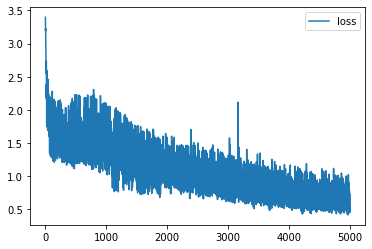

In [236]:
import random
from IPython.display import clear_output

model = LstmMusicGenerator(max_len)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
history = []

for i in range(5000):
   
    model.zero_grad()
    
    rand = random.randint(0, len(midis) - 1)

    sequence = prepare_sequence(midis[rand], token_to_id)
    targets = torch.tensor(np.roll(sequence.numpy(), -1), dtype=torch.long)
    
    tag_scores = model(sequence)

    loss = loss_function(tag_scores, targets)
    loss.backward()
    optimizer.step()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()


# with torch.no_grad():
#     inputs = prepare_sequence(training_data[0][0], word_to_ix)
#     tag_scores = model(inputs)
#     print(tag_scores)

In [237]:
def generate_sample():
    with torch.no_grad():
        inputs = torch.zeros(max_len, dtype=torch.long)
        tag_scores = model(inputs).numpy()
        tag_scores = np.argmax(tag_scores, axis=1)
    return [tokens[ix] for ix in tag_scores]

In [238]:
print(generate_sample())

['F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'F2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2', 'A#2']


# Training Model(RNN)

In [261]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, int64[batch_size]
        :param h_prev: previous rnn hidden states, float32 matrix [batch, rnn_num_units]
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        h_next = self.rnn_update(torch.cat((x_emb, h_prev), 1))
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units)

In [262]:
char_rnn = CharRNNCell()

In [263]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in lines_ix
    :param lines_ix: an int32 matrix of shape [batch, time], output of to_matrix(lines)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [264]:
batch_ix = to_matrix(midis[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(batch_ix)

logp_seq = rnn_loop(char_rnn, batch_ix)

print(torch.argmax(logp_seq, dim = 2))

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

tensor([[ 0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  1,  0,  0,  0,  1,
          0,  1,  0,  1,  0,  1,  0,  1,  0,  2,  0,  1,  0,  0],
        [ 0, 14,  0,  0, 14,  0,  0, 14,  0, 17,  0, 17,  0, 17,  0, 16,  0, 13,
          0,  0, 13,  0,  0, 13,  0, 14,  0, 14,  0, 14,  0,  8],
        [ 0,  7,  0,  0,  7,  0,  0,  7,  0, 11,  0, 11,  0, 11,  0, 10,  0,  5,
          0,  0,  5,  0,  0,  5,  0,  7,  0,  7,  0,  7,  0,  1],
        [ 0,  1,  0,  0,  1,  0,  0,  1,  0,  7,  0,  7,  0,  7,  0,  5, 10,  3,
          0,  0,  3,  0,  0,  3,  0,  1,  0,  1,  0,  1,  3, 16],
        [ 0,  8,  0,  0,  0, 14,  0, 14,  0, 14,  0, 14,  0, 17,  0,  0,  0,  8,
          0,  0,  0, 14,  0, 14,  0, 14,  0, 14,  0,  4,  0,  0]])
tensor([[ 6,  3,  6,  3, 15,  3,  6,  3, 15,  3, 15, 11,  2,  3,  6, 11,  2,  3,
          6,  3, 15,  3,  6,  3, 15,  3, 15,  3, 15,  3,  6, 11],
        [ 6,  6, 15,  2,  2, 15,  2,  2, 15, 15,  6, 13,  6, 16,  6, 15,  6,  3,
          6,  6,  3,  6,  6,  3,  6,

In [265]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

loss = -logp_next.mean()

In [266]:
loss.backward()

In [267]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

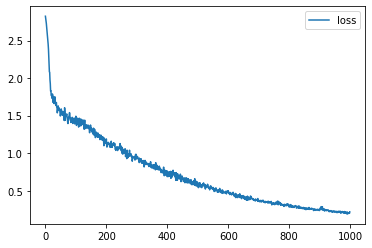

In [268]:
for i in range(1000):
    batch_ix = to_matrix(sample(list(midis), 16), max_len=max_len)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

    loss = -logp_next.mean()
    
    # train with backprop
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

In [271]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=max_len, temperature=1.0):
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return [tokens[ix] for ix in x_sequence.data.numpy()[0]]

In [334]:
print(generate_sample(char_rnn))

[' ', 'G#2', ' ', ' ', 'G#2', ' ', ' ', 'G#2', ' ', ' ', ' ', 'F2', ' ', 'F2', ' ', 'F2', ' ', 'B2', ' ', ' ', 'B2', ' ', ' ', 'B2', ' ', ' ', ' ', 'C#3', ' ', 'B2', ' ', ' ']


# Saving Data

In [380]:
def chd2ary(chd):
    res = np.array(np.zeros(88), dtype=np.int32)
    res = np.expand_dims(res, axis=0)
    pos = 0
    for i in range(len(chd)):
        elem = np.zeros(88, dtype=np.int32)
        if chd[pos] != ' ':
            elem[librosa.note_to_midi(chd[pos])] = 100
        for j in range(24):
            res = np.vstack((res, elem))
        pos = pos + 1
    return res[1:]

In [381]:
generated = generate_sample(char_rnn)
print(generated, '\n\n')

ary = chd2ary(generated)
print(ary)

[' ', 'A#2', ' ', ' ', ' ', 'F#2', ' ', 'F2', ' ', ' ', ' ', 'F#2', ' ', ' ', ' ', ' ', ' ', 'G#2', ' ', ' ', 'D3', 'C#3', 'D#3', 'B2', 'A#2', ' ', 'G#2', ' ', 'G#2', ' ', 'G#2', ' '] 


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0

In [386]:
len(compress(arry2chd(ary)))

34